In [1]:
%matplotlib notebook
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools
import scipy.sparse as sp
import scipy.sparse.linalg as spla

In [2]:
def html_table(lol, headers, string_formating='{:15.8g}'):
    assert len(lol) == len(headers)
    n = len(lol[0])
    for l in lol:
        assert len(l) == n
    ret = '<table class="data center">\n'
    for header in headers:
        ret += '\t<th>' + header + '</th>'
    ret += '\n'
    rows = zip(*lol)
    for row in rows:
        ret += '\t<tr>\n\t\t'
        for v in row:
            if isinstance(v, str):
                str_val = v
            else:
                str_val = string_formating.format(v)
            ret += '<td>' + str_val + '</td>'
        ret += '\n\t</tr>\n'
    ret += '</table>'
    return ret

# ODEs Time-Stepping

The ODE $y^\prime = \lambda y$ with the initial condition $y(0) = 1$ has the solution
$$
y(t) = e^{\lambda t}
$$

In [37]:
def foo(y_0, t, lam):
    return np.exp(lam*t)

def forward(y_0, delta_t, lam, n):
    return y_0 * (1+lam*delta_t)**n
        
def backward(y_0, delta_t, lam, n):
    return y_0 * (1-lam*delta_t)**-n

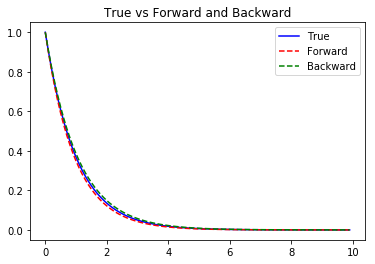

In [35]:
delta_t = .1
n = 100
lam = -1
y_0 = 1

ts = [delta_t * i for i in range(n)]
y_true = [foo(y_0, delta_t*i, lam) for i in range(n)]
y_forward = [forward(y_0, delta_t, lam, i) for i in range(n)]
y_backward = [backward(y_0, delta_t, lam, i) for i in range(n)]

plt.title('True vs Forward and Backward')
plt.plot(ts, y_true, '-b', label='True')
plt.plot(ts, y_forward, '--r', label='Forward')
plt.plot(ts, y_backward, '--g', label='Backward')
plt.legend()

In [100]:
target_t = 5
time_steps = [2**i for i in range(1,20)]
lam = -1
y_0 = 1

fw_errors = []
bk_errors = []

steps = [target_t/t for t in time_steps]

for step in time_steps:
    delta_t = target_t/step
    fw = forward(y_0, delta_t, lam, step)
    back = backward(y_0, delta_t, lam, step)
    true_value = foo(y_0, target_t, lam)
    fw_errors.append(np.abs(fw - true_value))
    bk_errors.append(np.abs(back - true_value))
    
print('fw_err\t\tfw_ratio\tback_err\tback_ratio')
print('%f\tN/A \t\t%f\tN/A  ' % (fw_errors[0], bk_errors[0]) )
for fw, fw_prev, bk, bk_prev in zip(fw_errors[1:], fw_errors[:-1], bk_errors[1:], bk_errors[:-1]):
    print('%f\t%f\t%f\t%f' % (fw, fw/fw_prev, bk, bk/bk_prev))
    
        


fw_err		fw_ratio	back_err	back_ratio
136.163159	N/A 		147.968715	N/A  
122.784253	0.901744	107.586841	0.727092
99.791819	0.812741	2408.699476	22.388421
70.861875	0.710097	253.041738	0.105053
44.263977	0.624652	81.285708	0.321234
25.152788	0.568245	33.972039	0.417934
13.475265	0.535736	15.654073	0.460793
6.984065	0.518288	7.527161	0.480844
3.556640	0.509251	3.692314	0.490532
1.794867	0.504652	1.828779	0.495293
0.901621	0.502333	0.910098	0.497654
0.451863	0.501168	0.453983	0.498828
0.226196	0.500584	0.226726	0.499415
0.113164	0.500292	0.113297	0.499707
0.056599	0.500146	0.056632	0.499854
0.028303	0.500073	0.028312	0.499927
0.014153	0.500037	0.014155	0.499963
0.007077	0.500018	0.007077	0.499982
0.003538	0.500009	0.003539	0.499991


In [19]:
l = zip(fw_errors[1:], fw_errors[:-1], bk_errors[1:], bk_errors[:-1])
for a, b, c, d in l:
    print(a,b,c,d)

0.09813016014842982 0.36787944117144233 0.07316613614786646 0.13212055882855767
0.04029005673169514 0.09813016014842982 0.03594125654955485 0.07316613614786646
0.018421153106358418 0.04029005673169514 0.017533267781211725 0.03594125654955485
0.00882228696598622 0.018421153106358418 0.00862363532858676 0.017533267781211725
0.004318736626198916 0.00882228696598622 0.004271903885053968 0.00862363532858676
0.00213681456395598 0.004318736626198916 0.002125455235711504 0.004271903885053968
0.0010628353081024722 0.00213681456395598 0.0010600387870733918 0.002125455235711504
0.0005300328463224702 0.0010628353081024722 0.000529339111767918 0.0010600387870733918


# Systems of ODEs

In [3]:
def solution_u(t):
    return (1+3*np.exp(-8/3*t))/8
def solution_v(t):
    return -3*np.exp(-8/3*t)

def solution(t):
    return np.array([solution_u(t), solution_v(t)])

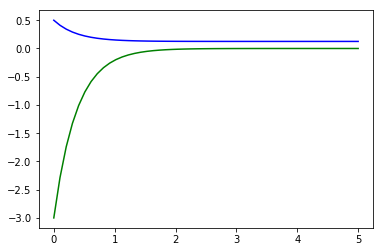

In [4]:
ts = np.linspace(0, 5)
plt.plot(ts, solution_u(ts), 'b-')
plt.plot(ts, solution_v(ts), 'g-')

In [29]:
def foo(z):
    u, v = z[0], z[1]
    return np.array((1/3 * v, v*(v-1)/(3*u)))

z0 = np.array([.5, -3])

def forward(delta_t, n):
    z = z0*1
    for i in range(n):
        z += delta_t * foo(z)
    return z

def backward(delta_t, n):
    A = delta_t/3
    u, v = z0[0], z0[1]
    for i in range(n):
        v = v*(u)/(u-A*v+A)
        u += A*v
    return np.array([u,v])

In [30]:
target_t = .5
time_steps = [2**i for i in range(1,20)]

fw_errors = []
bk_errors = []

steps = [target_t/t for t in time_steps]
true_value = solution(target_t)
for step in time_steps:
    delta_t = target_t/step
    fw = forward(delta_t, step)
    back = backward(delta_t, step)
    fw_errors.append(la.norm(fw - true_value))
    bk_errors.append(la.norm(back - true_value))
    
print('fw_err\t\tfw_ratio\tback_err\tback_ratio')
print('%f\tN/A \t\t%f\tN/A  ' % (fw_errors[0], bk_errors[0]) )
for fw, fw_prev, bk, bk_prev in zip(fw_errors[1:], fw_errors[:-1], bk_errors[1:], bk_errors[:-1]):
    print('%f\t%f\t%f\t%f' % (fw, fw/fw_prev, bk, bk/bk_prev))

fw_err		fw_ratio	back_err	back_ratio
0.461018	N/A 		0.291459	N/A  
0.199741	0.433261	0.159660	0.547796
0.093812	0.469666	0.083928	0.525667
0.045546	0.485503	0.043083	0.513337
0.022450	0.492907	0.021835	0.506803
0.011146	0.496491	0.010992	0.503436
0.005554	0.498255	0.005515	0.501727
0.002772	0.499130	0.002762	0.500866
0.001385	0.499565	0.001382	0.500433
0.000692	0.499783	0.000691	0.500217
0.000346	0.499891	0.000346	0.500108
0.000173	0.499946	0.000173	0.500054
0.000086	0.499973	0.000086	0.500027
0.000043	0.499986	0.000043	0.500014
0.000022	0.499993	0.000022	0.500007
0.000011	0.499997	0.000011	0.500003
0.000005	0.499998	0.000005	0.500002
0.000003	0.499999	0.000003	0.500000
0.000001	0.500000	0.000001	0.500004


# 1-D Heat Equation

In [3]:
from heat_equation import *
c = 1
'''
def f(x):
    return np.sin(x*2*np.pi)
f = np.vectorize(f)
def u(x,t):
    return np.sin(x*2*np.pi)*np.exp(-(2*np.pi)**2 * t)
'''

def f(x):
    return x**2 * (1-x)
f = np.vectorize(f)
u = dirichlet_solution(c,f)
#u = dirichlet_solution(c,f, n=40)



# Time-step n steps
def forward(u0, D, delta_t, num_steps):
    u = u0
    for i in range(num_steps):
        u = u + delta_t * D@u
    return u

def backward(u0, D, delta_t, num_steps):
    u = u0
    L = sp.eye(D.shape[0]) - delta_t*D
    for i in range(num_steps):
        u = spla.spsolve(L, u)
    return u

def bdf2(u0, D, delta_t, num_steps):
    u1 = u0
    L = sp.eye(D.shape[0]) - delta_t*D
    # one step of backward Euler
    u2 = spla.spsolve(L, u1)
    # continue with BDF2
    L = 3/2*sp.eye(D.shape[0]) - delta_t*D
    for i in range(num_steps-1):
        u_3 = spla.spsolve(L, 2*u2 - .5*u1)
        u1, u2 = u2, u_3
    return u2

In [15]:
target_t = .1 # Time at which we are evaluating the error
time_steps = [2**i for i in range(2,12)] # List of the number of steps we are taking.

fw_errors = []
bk_errors = []


for num_steps in time_steps:
    delta_t = target_t/num_steps
    ###################################################################
    # Choice of n affects order of convergence
    
    n = num_steps + 1
    #n = int(np.sqrt(num_steps)) + 1
    #n = int(num_steps**1.7)
    #n = max(int(num_steps**2 *1), 2)
        
    ###################################################################
    print('Processing num_steps=%d \t n=%d' % (num_steps, n) )
    h = 1/(n-1)
    D = sp.diags([1] + [-2]*(n-2) + [1]) + sp.diags([0] + [1]*(n-2), 1) + sp.diags([1]*(n-2) + [0], -1)
    D = h**-2 * D
    D[0,0] = 1
    D[n-1,n-1] = 1
    #print(D)
    xs = np.linspace(0,1, n)
    u0 = f(xs)
    true_value = u(xs, target_t)
    fw = forward(u0, D, delta_t, num_steps)
    #back = backward(u0, D, delta_t, num_steps)
    back = bdf2(u0, D, delta_t, num_steps)
    fw_errors.append(la.norm(fw - true_value))
    bk_errors.append(la.norm(back - true_value))
    
print('fw_err       fw_ratio       back_err       back_ratio')
print('%10.5g        N/A       %10.5g       N/A  ' % (fw_errors[0], bk_errors[0]) )
for fw, fw_prev, bk, bk_prev in zip(fw_errors[1:], fw_errors[:-1], bk_errors[1:], bk_errors[:-1]):
    print('%10.5g    %10.5g    %10.5g    %10.5g' % (fw, fw/fw_prev, bk, bk/bk_prev) )

Processing num_steps=4 	 n=5
Processing num_steps=8 	 n=9
Processing num_steps=16 	 n=17
Processing num_steps=32 	 n=33
Processing num_steps=64 	 n=65
Processing num_steps=128 	 n=129
Processing num_steps=256 	 n=257
Processing num_steps=512 	 n=513


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in add


Processing num_steps=1024 	 n=1025
Processing num_steps=2048 	 n=2049
fw_err       fw_ratio       back_err       back_ratio
 0.0055293        N/A        0.0056221       N/A  
   0.26938        48.718     0.0018983       0.33766
5.8006e+07    2.1533e+08    0.00065895       0.34712
3.4844e+29    6.0069e+21    0.00023133       0.35106
2.7711e+83     7.953e+53    8.1538e-05       0.35247
       inf           inf    2.8787e-05       0.35305
       nan           nan    1.0171e-05       0.35331
       nan           nan    3.5947e-06       0.35343
       nan           nan    1.2706e-06       0.35347
       nan           nan    4.4905e-07       0.35341


In [32]:
.5*np.sqrt(.5)

0.3535533905932738

<IPython.core.display.Javascript object>


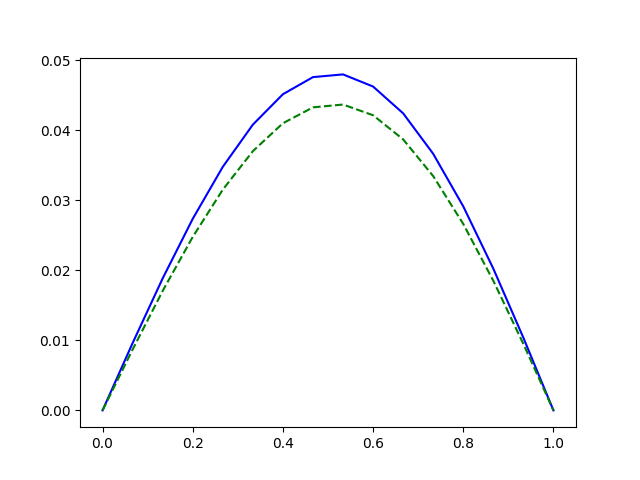

31177410.125865437


In [191]:
num_steps = 16
target_t = .1

n = num_steps

##################################################################################

delta_t = target_t/num_steps
h = 1/n
D = sp.diags([1] + [-2]*(n-2) + [1]) + sp.diags([0] + [1]*(n-2), 1) + sp.diags([1]*(n-2) + [0], -1)
D = h**-2 * D
D[0,0] = 1
D[n-1,n-1] = 1
#print(D)
xs = np.linspace(0,1, n)
u0 = f(xs)
true_value = u(xs, target_t)
fw = forward(u0, D, delta_t, num_steps)
back = backward(u0, D, delta_t, num_steps)



plt.plot(xs, true_value, 'b-')
#plt.plot(xs, fw, 'r-.')
plt.plot(xs, back, 'g--')

print(np.max(np.abs( u0 - forward(u0, D, delta_t, num_steps) )))

# Animation Testing

<IPython.core.display.Javascript object>


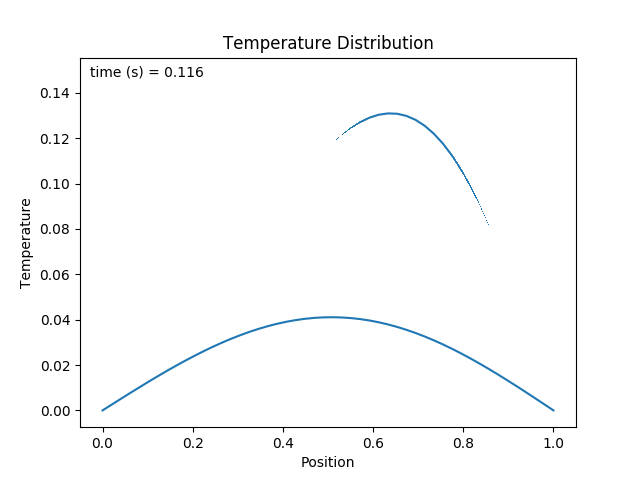

In [118]:
from heat_equation import *
def f(x):
    return x**2 * (1-x)
u = dirichlet_solution(1,f)
x = np.linspace(0,1)

import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
plt.xlabel('Position')
plt.ylabel('Temperature')
plt.title('Temperature Distribution')

line, = ax.plot(x, f(x))
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)


def animate(i):
    line.set_ydata(u(x,i/1000))  # update the data
    time_text.set_text('time (s) = %.3f' % (i/1000))
    return line, time_text


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    time_text.set_text('')
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)

ani.save('1D-heat.mp4', writer='imagemagick', fps=30)

plt.show()

In [225]:
fw_ratio = ['N/A'] + [e/p for e, p in zip(fw_errors[1:], fw_errors[:-1])]
bk_ratio = ['N/A'] + [e/p for e, p in zip(bk_errors[1:], bk_errors[:-1])]
print(html_table(([target_t/n for n in time_steps], fw_errors, fw_ratio, bk_errors, bk_ratio), ('$\Delta t$', 'fw_err','fw_ratio','bk_err','bk_ratio')))

<table class="data center">
	<th>$\Delta t$</th>	<th>fw_err</th>	<th>fw_ratio</th>	<th>bk_err</th>	<th>bk_ratio</th>
	<tr>
		<td>          0.025</td><td>  6.1171839e-18</td><td>N/A</td><td>  6.1171839e-18</td><td>N/A</td>
	</tr>
	<tr>
		<td>         0.0125</td><td>  6.1171839e-18</td><td>              1</td><td>  6.1171839e-18</td><td>              1</td>
	</tr>
	<tr>
		<td>        0.00625</td><td>    0.029786062</td><td>  4.8692441e+15</td><td>    0.024693141</td><td>  4.0366843e+15</td>
	</tr>
	<tr>
		<td>       0.003125</td><td>    0.027337333</td><td>     0.91778944</td><td>    0.024504521</td><td>     0.99236146</td>
	</tr>
	<tr>
		<td>      0.0015625</td><td>    0.022910183</td><td>     0.83805478</td><td>    0.021194308</td><td>     0.86491419</td>
	</tr>
	<tr>
		<td>     0.00078125</td><td>    0.019786197</td><td>     0.86364202</td><td>    0.018810993</td><td>     0.88754928</td>
	</tr>
	<tr>
		<td>    0.000390625</td><td>    0.016585217</td><td>     0.83822156</td><td>    0.0

In [82]:
isinstance('a', str)

True